In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

import sys
sys.path.append("../../..")
from utils.plotting_utils import plots
from utils import postprocessing_utils as post

In [2]:
def prepare_table(params):
    M = post.Metrics(**params)
    df = M.transfer_loss(grouped_train=True, grouped_test=True)
    df_same = df[df["Train-Group"] == df["Test-Group"]]
    df_others = df[df["Train-Group"] != df["Test-Group"]]
    df_same.loc[:, "Test-Group"] = "Intra-Group"
    df_others = df_others.groupby("Train-Group", sort=False, as_index=False).mean()
    df_others["Test-Group"] = "Inter-Group"
    final = pd.concat([df_same, df_others]).reset_index(drop=True)
    if params["short_model_name"] == "mbert":
        final["Model"] = "mBERT"
    elif params["short_model_name"] == "xlm-roberta":
        final["Model"] = "XLM"
    return final

In [3]:
def transfer_plot(title, save_to, ylim_mbert, ylim_xlm):
    plots.prepare_sns()
    sns.set_context("paper", font_scale=3)

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    colors = {k: sns.saturate(v) for k, v in plots.get_group_colors(as_dict=True).items()}
    markers = {"Fusional": "o",
               "Isolating": "X",
               "Agglutinative": (5, 1),
               "Introflexive": "^"}

    g1 = sns.lineplot(x="Test-Group", 
                      y="Transfer-Loss", 
                      hue="Train-Group", 
                      data=final[final["Model"] == "mBERT"],
                      palette=colors, 
                      linewidth=4, 
                      ax=ax[0], 
                      legend=False, 
                      dashes=False, 
                      style="Train-Group", 
                      markers=markers, 
                      markersize=15,
                      markeredgewidth=3.5,
                      path_effects=[pe.PathPatchEffect(linewidth=6.5, edgecolor="black"), pe.Normal()])
        
    g2 = sns.lineplot(x="Test-Group", 
                      y="Transfer-Loss", 
                      hue="Train-Group", 
                      data=final[final["Model"] == "XLM"],
                      palette=colors, 
                      linewidth=4, 
                      ax=ax[1], 
                      legend=False, 
                      dashes=False, 
                      style="Train-Group", 
                      markers=markers, 
                      markersize=15,
                      markeredgewidth=3.5,
                      path_effects=[pe.PathPatchEffect(linewidth=6.5, edgecolor="black"), pe.Normal()])
    
    for i, group in enumerate(colors.keys()):
        g1.lines[i].set_markeredgecolor(colors[group])
        g2.lines[i].set_markeredgecolor(colors[group])

    ax[0].set_title("mBERT")
    ax[0].set_ylim(ylim_mbert)
    ax[0].set_ylabel("Transfer Loss")
    ax[0].set_xlabel("Transfer Type")
    ax[0].legend(colors.keys(), title="Train Group", bbox_to_anchor=(1.1, 0.5))
    ax[1].set_title("XLM-R")
    ax[1].set_ylim(ylim_xlm)
    ax[1].set_ylabel("")
    ax[1].set_xlabel("Transfer Type")

    fig.suptitle(title, y=1.05)

    sns.despine()
    plt.show()
    if save_to:
        fig.savefig(save_to, dpi=400, bbox_inches="tight")
    plt.close()

### PoS

In [4]:
params = {
    "results_dir": "../../../results/",
    "experiment": "acl-score-limit",
    "task": "pos",
    "short_model_name": "mbert",
    "metric": "Accuracy"
}

# mBERT
final = prepare_table(params)

# XLM
params["short_model_name"] = "xlm-roberta"
final = pd.concat([final, prepare_table(params)])

final["Transfer-Loss"] *= 100

e:\anaconda\envs\tfm_ccil\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
final[final["Test-Group"] == "Inter-Group"].groupby("Model").agg(lambda x: x.max() - x.min())

,Within-Score,Cross-Score,Transfer-Loss
Model,,,
XLM,0.013690,0.041643,2.869576
mBERT,0.015241,0.047973,3.929100


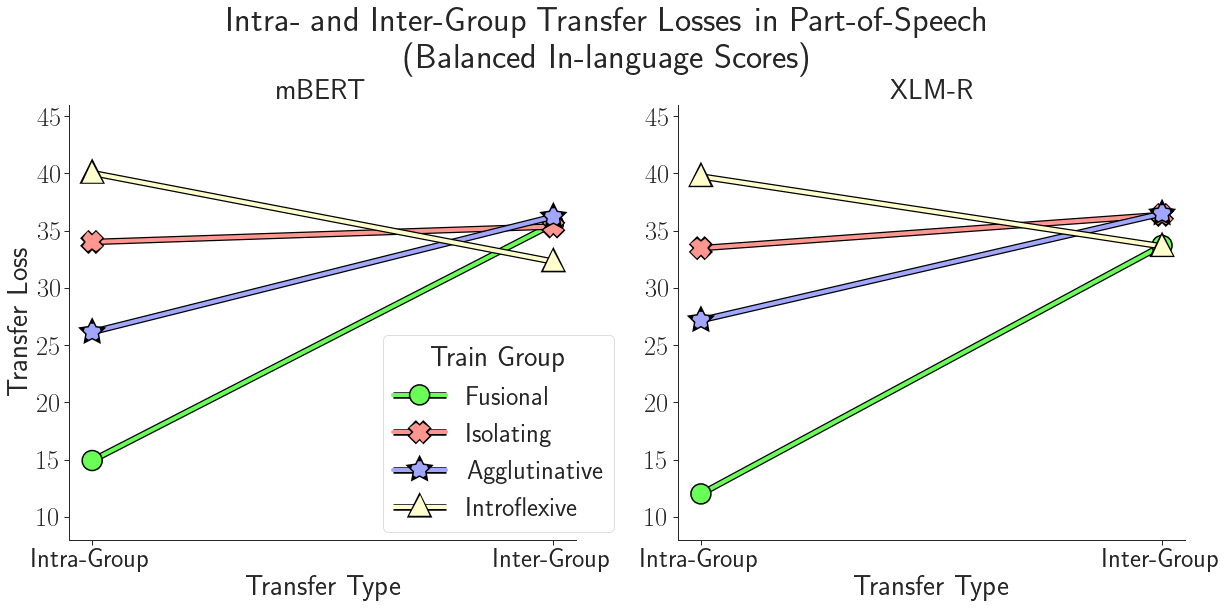

In [26]:
title = "Intra- and Inter-Group Transfer Losses in Part-of-Speech\n(Balanced In-language Scores)"
save_to = params["results_dir"] + "acl-score-limit/plots/transfer_plot_pos.pdf"

transfer_plot(title, save_to, ylim_mbert=(8, 46), ylim_xlm=(8, 46))

### Sentiment

In [27]:
params = {
    "results_dir": "../../../results/",
    "experiment": "acl-score-limit",
    "task": "sentiment",
    "short_model_name": "mbert",
    "metric": "Macro_F1"
}

# mBERT
final = prepare_table(params)

# XLM
params["short_model_name"] = "xlm-roberta"
final = pd.concat([final, prepare_table(params)])

final["Transfer-Loss"] *= 100

e:\anaconda\envs\tfm_ccil\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


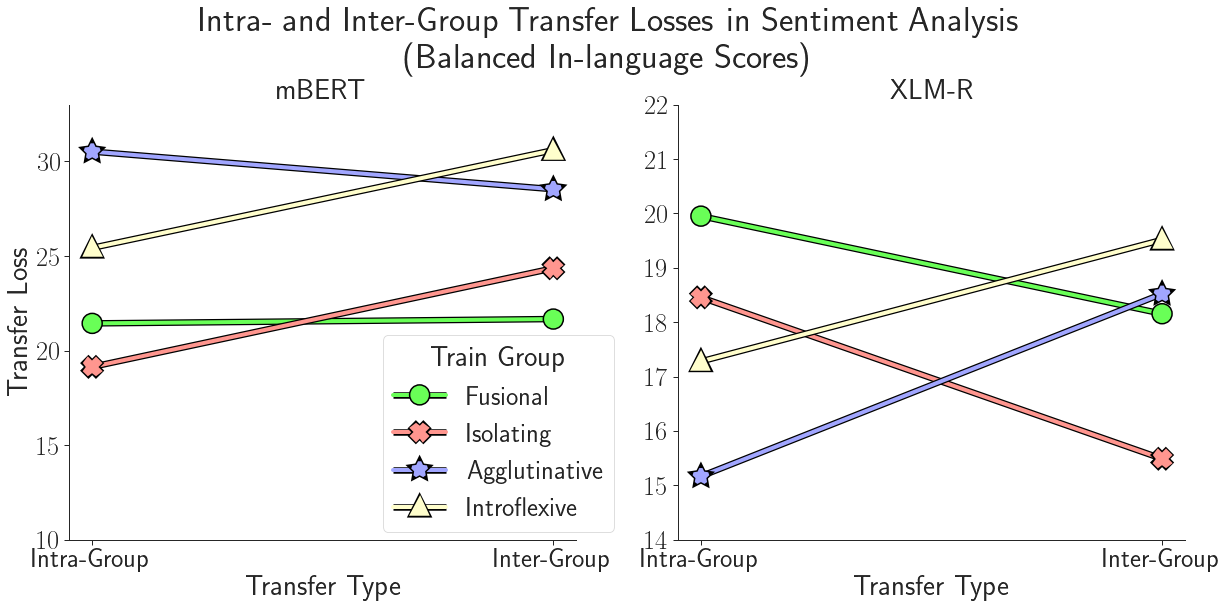

In [28]:
title = "Intra- and Inter-Group Transfer Losses in Sentiment Analysis\n(Balanced In-language Scores)"
save_to = params["results_dir"] + "acl-score-limit/plots/transfer_plot_sentiment.pdf"

transfer_plot(title, save_to, ylim_mbert=(10, 33), ylim_xlm=(14, 22))